In [1]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using BenchmarkTools

using SciPy
using Statistics
using StaticArrays
using CairoMakie

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end

HR (generic function with 1 method)

In [3]:
function peaks(x)
    peaks_ = Float64[]
    len_ = length(x)
    for i in range(2, len_ - 1, step = 1)
        if x[i-1] < x[i] > x[i+1]
            push!(peaks_, x[i])
        end
    end
    return peaks_
end

function local_min(x)
    
    peaks_ = Float64[]
    len_ = length(x)
    
    for i in range(2, len_ - 1, step = 1)
        if x[i-1] > x[i] < x[i+1]
            push!(peaks_, x[i])
        end
    end
    return peaks_
end

local_min (generic function with 1 method)

In [4]:
function CALCPDF(spikes)
    ϵ = 0.9
    ee_counter = [sum(i->s<=i<s+ϵ, spikes) for s in range(0,4,5000000)]
    pdf = ee_counter ./ length(spikes)
    return range(0,4,5000000), pdf
end

CALCPDF (generic function with 1 method)

In [5]:
tspan = (0., 300000.)

a = 1.
b = 3.
c = 1.
d = 5.
xr = -1.6
r = 0.01 # 0.01
s = 5.
I = 4.
xv = 2.

k1= 0.07
k2 = k1
k = 0.0;

In [5]:
p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, k2, k]

initialcondition = SA[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0];

In [6]:
prob = ODEProblem(HR, initialcondition, tspan, p)


ODEProblem with uType SVector{6, Float64} and tType Float64. In-place: false
timespan: (0.0, 300000.0)
u0: 6-element SVector{6, Float64} with indices SOneTo(6):
 -1.5
  0.0
  0.0
 -2.5
  0.0
  0.0

In [7]:
sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000);

In [13]:
xsum = sol[1, :] + sol[4, :];
length(xsum)

3680739

In [14]:
xsum = xsum[floor(Int, length(xsum) / 2):end ]
length(xsum)

1840371

In [18]:
spikes = peaks(xsum);
length(spikes)

9236

In [86]:
all_peaks_ = all_peaks(xsum);

8.39211857177879

In [109]:
Hs(x, k) = Statistics.mean(x) + k * Statistics.std(x)

Hs (generic function with 1 method)

In [42]:
Hs1 = Hs(xsum, 6)
Hs2 = Hs(spikes, 6)

4.377753852747872

In [37]:
using StatsBase

In [46]:
percentile_full = percentile(xsum, 99.9)
percentile_spikes = percentile(spikes, 99.9)

3.518939229112294

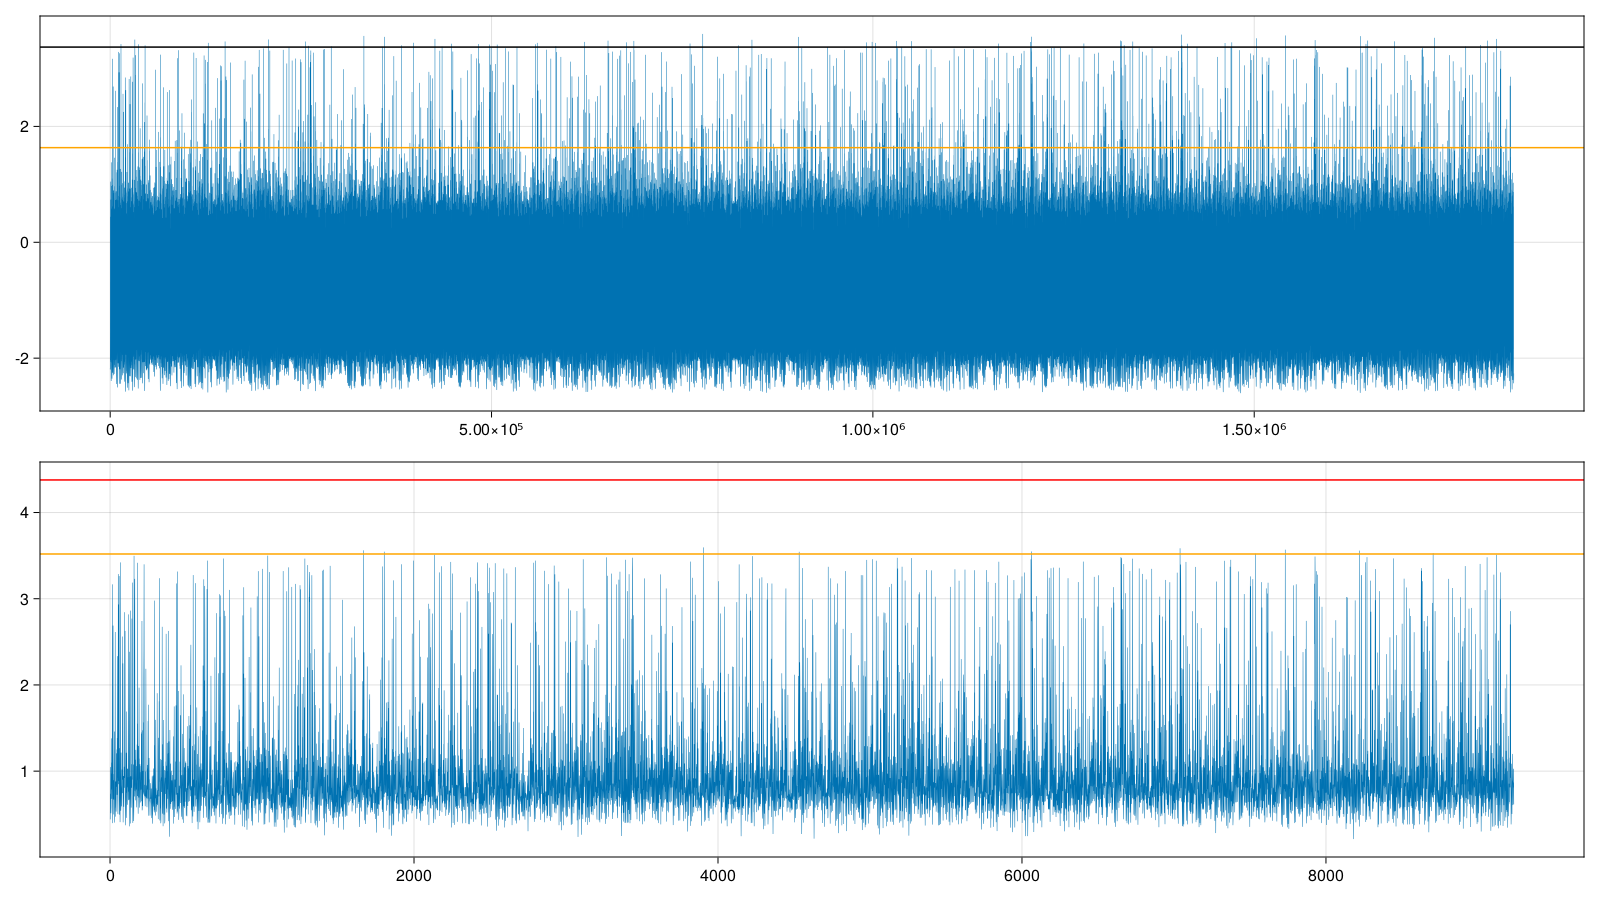

In [47]:
f = Figure(resolution = (1600, 900))
ax1 = Axis(f[1, 1])
ax2 = Axis(f[2, 1])

lines!(ax1, xsum, linewidth = 0.5)

hlines!(ax1, Hs1, linewidth = 1.5, color = "black")
hlines!(ax1, percentile_, linewidth = 1.5, color = "orange")

lines!(ax2, spikes, linewidth = 0.5)

hlines!(ax2, Hs2, linewidth = 1.5, color = "red")
hlines!(ax2, percentile_spikes, linewidth = 1.5, color = "orange")
f

In [53]:
sel_, pdf_ = CALCPDF(spikes);

LoadError: UndefVarError: pdf not defined

In [66]:
typeof(sel_)

StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}

In [64]:
typeof(pdf_)

Vector{Float64} (alias for Array{Float64, 1})

In [67]:
typeof(spikes)

Vector{Float64} (alias for Array{Float64, 1})

In [80]:
f = Figure(resolution = (1600, 900))
ax = Axis(f[1, 1], yscale = log10)
lines!(ax, sel_, pdf_)
f

Figure()

In [6]:
using JLD

In [7]:
cd("C:\\Users\\olenin.s\\Downloads\\Telegram Desktop")

In [8]:
condition_matrix = load("condition_HR_array.jld")["data"]

6×1001 Matrix{Float64}:
 -1.5  -0.821655  -0.933591  -1.23227   …   1.09712  -0.877814  -1.22517
  0.0  -2.6845    -3.57091   -6.78991      -5.44587  -2.68542   -6.6041
  0.0   3.85217    3.83131    3.61857       4.00611   4.32268    3.72831
 -2.5  -0.988046  -1.11302   -0.867708      1.09712  -0.877814  -1.22517
  0.0  -4.05301   -5.02094   -2.98657      -5.44587  -2.68542   -6.6041
  0.0   3.81876    4.08909    3.89541   …   4.00611   4.32268    3.72831

In [9]:
condition_matrix[:, 302]

6-element Vector{Float64}:
  -1.513912324685364
 -10.189993363489231
   4.3601943250184805
   1.1534297707254306
  -1.2540949837622415
   3.817275625664453

In [ ]:
cond = SA[ -1.513912324685364,
 -10.189993363489231,
   4.3601943250184805,
   1.1534297707254306,
  -1.2540949837622415,
   3.817275625664453]

In [119]:
p = SA[a, b, c, d,
        s, xr, r, I, xv, -0.17, -0.17, 0.301]

prob = ODEProblem(HR, cond, (tspan), p)

ODEProblem with uType SVector{6, Float64} and tType Float64. In-place: false
timespan: (0.0, 300000.0)
u0: 6-element SVector{6, Float64} with indices SOneTo(6):
  -1.513912324685364
 -10.189993363489231
   4.3601943250184805
   1.1534297707254306
  -1.2540949837622415
   3.817275625664453

In [120]:
sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000);

In [121]:
xsum = sol[1, :] + sol[4, :];
length(xsum)

4952307

In [122]:
xsum = xsum[floor(Int, length(xsum) / 2):end ]
length(xsum)

2476155

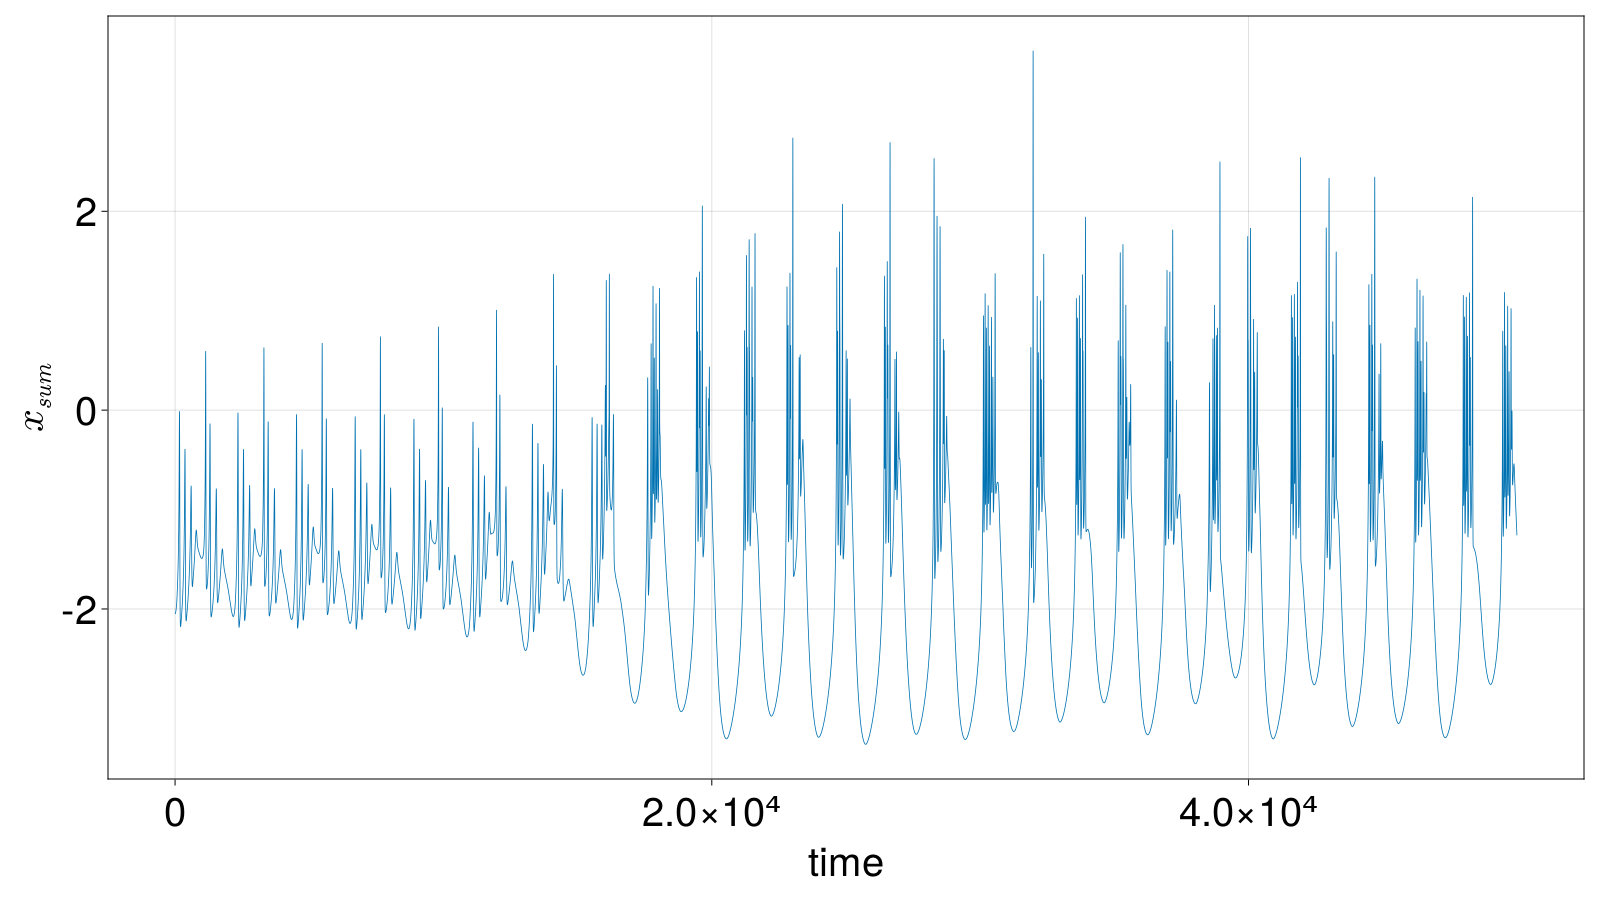

In [101]:
f = Figure(resolution=(1600, 900), fontsize = 40)
ax = Axis(f[1, 1], xlabel="time", ylabel=L"x_{sum}")
lines!(ax, xsum[670000:720000], linewidth = 0.8)
f

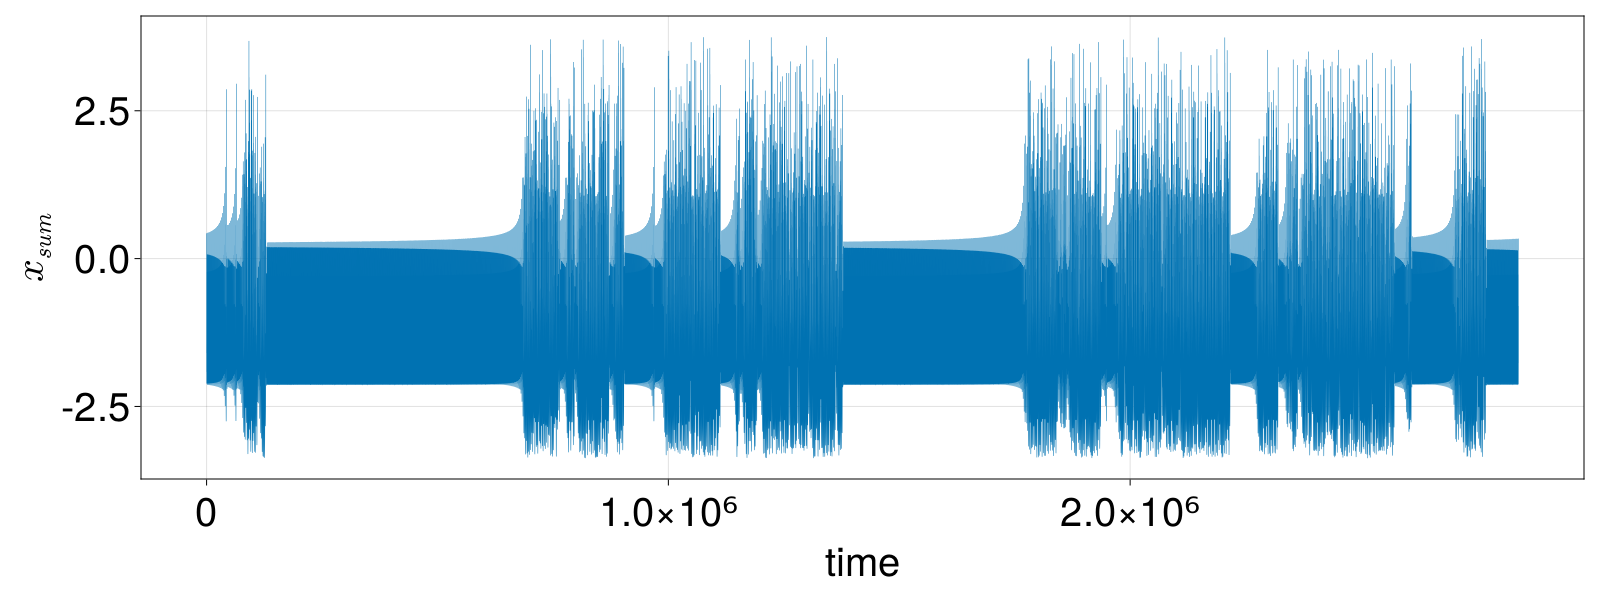

In [82]:
f = Figure(resolution=(1600, 600), fontsize = 40)
ax = Axis(f[1, 1], xlabel="time", ylabel=L"x_{sum}")
lines!(ax, xsum, linewidth = 0.5)
f

In [84]:
x1, x2 = sol[1, :], sol[4, :];
x1, x2 = x1[floor(Int, length(x1) / 2):end ], x2[floor(Int, length(x2) / 2):end ];
length(x1), length(x2)

(2840854, 2840854)

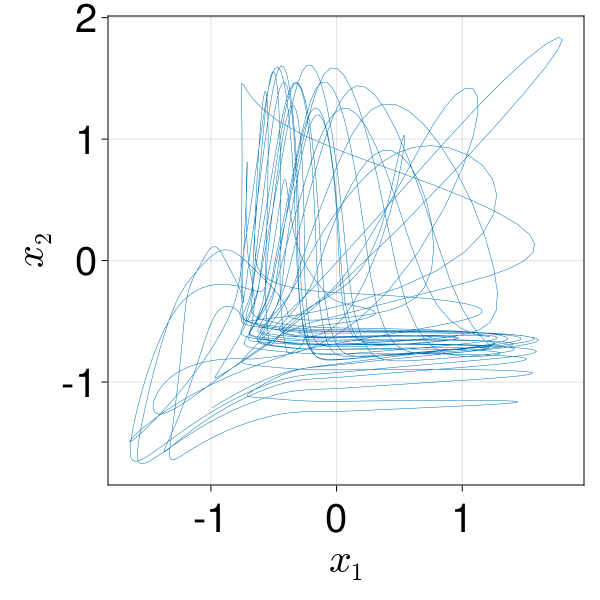

In [99]:
f = Figure(resolution=(600, 600), fontsize = 40)
ax = Axis(f[1, 1], xlabel=L"x_1", ylabel=L"x_2")
lines!(ax, x1[700000:710000], x2[700000:710000], linewidth = 0.5)
f